In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import email
import os

from bs4 import BeautifulSoup
from sklearn.base import BaseEstimator, TransformerMixin
from wordcloud import WordCloud
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ST\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Extraction from raw E-Mail Files.

In [4]:
root_dir = os.getcwd()

ham_folder = os.path.join(root_dir,'main_ham')
spam_folder = os.path.join(root_dir,'main_spam')
ham_files = os.listdir(ham_folder)
spam_files = os.listdir(spam_folder)

In [49]:
def clean_html(email):
    '''
    To clean any html content in emails.
    :param email: string of html tags and content
    :return: a clean string with no html tags or styling
    '''

    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "nothing"

In [50]:
def parse_email(path):
    with open(path, 'rb') as f:
        return email.parser.BytesParser().parse(f)

def email_to_text(mail):
    '''
    This function takes a parsed email and returns the content of the mail
    :param mail: parsed mail object
    :return: body content after cleaning any html tags present
    '''
    text_content = ""
    for part in mail.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        else:
            text_content += clean_html(part)

    return text_content

class EmailToText(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    def fit_transform(self, mail):
        return email_to_text(parse_email(mail))

In [51]:
extractor = EmailToText()

In [101]:
df = {}
for file in spam_files:
    df[extractor.fit_transform(os.path.join(spam_folder, file))] = 'spam'
for file in ham_files:
    df[extractor.fit_transform(os.path.join(ham_folder, file))] = 'ham'

In [102]:
data = pd.DataFrame.from_dict(df, orient='index', columns=['label']).reset_index(names='mail')
data.to_csv('datasets/data_v1.csv', index=False)
del df

In [54]:
data.shape

(6003, 2)

In [55]:
data.head()

,mail,label
0,mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nm...,spam
1,Greetings!\n\nYou are receiving this letter be...,spam
2,</TR> Save up to 70% on Life Insurance. Why Sp...,spam
3,"The Need For Safety Is Real In 2002, You Might...",spam
4,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam


## Cleaning the Dataset and the body text.

In [56]:
data = data.drop(data[data['mail'] == 'nothing'].index, axis=0).reset_index(drop=True)

In [57]:
data.head()

,mail,label
0,mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nm...,spam
1,Greetings!\n\nYou are receiving this letter be...,spam
2,</TR> Save up to 70% on Life Insurance. Why Sp...,spam
3,"The Need For Safety Is Real In 2002, You Might...",spam
4,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam


In [58]:
data.iloc[0,0]

'mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nmv 10 00010.7f5fb525755c45eb78efc18d7c9ea5aa\nmv 100 00100.c60d1c697136b07c947fa180ba3e0441\nmv 101 00101.2dfd7ee79ae439b8d9c38e783a137efa\nmv 102 00102.2e3969075728dde7a328e05d19b35976\nmv 103 00103.8c39bfed2079f865e9dfb75f4416a468\nmv 104 00104.886f4a22362f4d3528c3e675878f17f7\nmv 105 00105.9790e1c57fcbf7885b7cd1719fb4681b\nmv 106 00106.fa6df8609cebb6f0f37aec3f70aa5b9a\nmv 107 00107.f1d4194b57840ea6587b9a73ed88e075\nmv 108 00108.4506c2ef846b80b9a7beb90315b22701\nmv 109 00109.601a9cd8272f22236b27e95dbe2fa22d\nmv 11 00011.2a1247254a535bac29c476b86c708901\nmv 110 00110.20934dc65c9a88fc9c6afda9952ce2c5\nmv 111 00111.a163d41592b3a52747d7521341a961af\nmv 112 00112.ec411d26d1f4decc16af7ef73e69a227\nmv 113 00113.ff113297f0ed07536d288c7b2193a8ec\nmv 114 00114.c104ada3a249e1e1846c0cd156a303e9\nmv 115 00115.d7c257361675ee5d45baa552205fb472\nmv 116 00116.8e13644b995f98dbab198b71e26f67ec\nmv 117 00117.33011fddf61efe5f453a14468ff7e629\nmv 118 00118.4be

In [59]:
data[data['mail'].str.match(r"mv (\d+) (\d{5})\.([a-f0-9]{32})", na=False)]

,mail,label
0,mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nm...,spam


In [60]:
data = data.drop(index = [0]).reset_index(drop=True)

In [17]:
data.head()

,mail,label
0,Greetings!\n\nYou are receiving this letter be...,spam
1,</TR> Save up to 70% on Life Insurance. Why Sp...,spam
2,"The Need For Safety Is Real In 2002, You Might...",spam
3,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam
4,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam


In [19]:
data.duplicated().sum()

np.int64(0)

In [35]:
def clean_text(test_mail):
    ps = PorterStemmer()

    test_mail = re.sub(r'\n', '', test_mail)
    test_mail = test_mail.lower()
    test_mail = re.sub(r'http\S+|www\.\S+', '', test_mail)
    test_mail = re.sub(r'\b[\w.-]+?@[\w.-]+\.\w+\b', '', test_mail)
    words = test_mail.split()
    filtered = [ps.stem(word) for word in words if word not in stopwords.words('english')]
    test_mail = ' '.join(filtered)
    test_mail = re.sub(r'[^\p{Sc}A-Za-z0-9 ]+', '', test_mail)
    test_mail = test_mail.strip()

    return test_mail

data['mail'] = data['mail'].apply(clean_text)

In [36]:
data['mail']

0       greetingsy receiv letter express interest rece...
1       tr save 70 life insur spend life quot save ens...
2       need safeti real 2002 might get one chanc read...
3       1 fight risk cancer slim guarante lose 1012 lb...
4       1 fight risk cancer slim guarante lose 1012 lb...
                              ...                        
5997    tmdanethistoryhtmlth first releas tmda april 2...
5998    justin mason wrote phil r lawrenc said someth ...
5999    wed 11 sep 2002 vinc puzzella wrote ever sinc ...
6000    craig hugh said header reproduc full address o...
6001    follow razor debug sequenc show mail go 9295 b...
Name: mail, Length: 6002, dtype: object

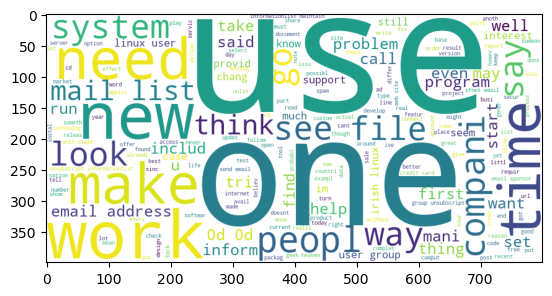

In [37]:
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate(" ".join(data['mail']))
plt.imshow(wc)

In [90]:
class CleanBody(BaseEstimator, TransformerMixin):
    '''
    transform a normal english email into preprocessed text optimal for spam classification
    '''

    def __init__(self):
        self.ps = PorterStemmer()
        self.stopwords = set(stopwords.words('english'))

    def transform(self, column):
        self.mails = column.values
        cleaned_mails = []
        for mail in self.mails:
            mail = re.sub(r'\n', '', mail)  # remove the raw newline character
            mail = mail.lower()  # turn everything into lowercase
            mail = re.sub(r'http\S+|www\.\S+', '', mail)  # remove all links
            mail = re.sub(r'\b[\w.-]+?@[\w.-]+\.\w+\b', '', mail)  # remove all e-mail addresses

            words = mail.split()
            filtered = [self.ps.stem(word) for word in words if word not in self.stopwords]   # remove all the stopwords
            mail = ' '.join(filtered)

            mail = re.sub(r'([!?])', r' \1 ', mail)  #
            mail = re.sub(r'\s+', ' ', mail)  # Normalize spaces

            mail = re.sub(r'[^\p{Sc}A-Za-z0-9 !?]+', '', mail)    # remove all special characters except spaces and currency symbols
            mail = mail.strip()    # remove trailing and leading whitespaces
            cleaned_mails.append(mail)

        return np.array(cleaned_mails).reshape(-1)


In [95]:
cleaner = CleanBody()

data['mail'] = cleaner.transform(data['mail'])

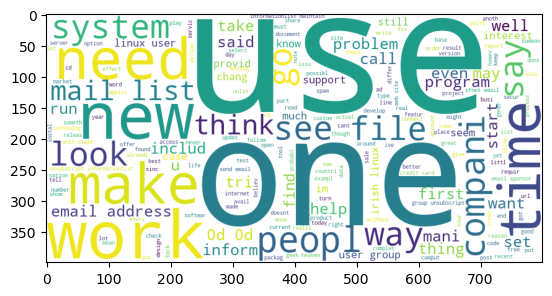

In [97]:
wc2 = WordCloud(width=800, height=400, background_color='white')
wc2.generate(" ".join(data['mail']))
plt.imshow(wc)

# Our class works! We can easily implement a pipeline now.

In [99]:
data.to_csv('datasets/data_v2.csv', index=False)